In [17]:

# ===============================================
# DC Motor Fehlerklassifizierung
# ===============================================

# 1. Benötigte Bibliotheken importieren
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

#Versionen ausgeben, um die korrekte Installation zu verifizieren
if __name__ == "__main__":
    print("pandas    version:", pd.__version__)
    print("numpy     version:", np.__version__)
    print("tensorflow version:", tf.__version__)
    try:
        import sklearn
        print("scikit-learn version:", sklearn.__version__)
    except ImportError:
        print("scikit-learn ist nicht installiert.")
    print("matplotlib version:", plt.matplotlib.__version__)



pandas    version: 2.2.3
numpy     version: 2.1.3
tensorflow version: 2.19.0
scikit-learn version: 1.6.1
matplotlib version: 3.10.3


In [18]:
# --------------------------------------------------
# 2. Daten laden
# --------------------------------------------------
file_path = "dc_motor_data.csv"
data = pd.read_csv(file_path)

# Erste Einträge anzeigen (optional)
print("\nErste Datenzeilen:")
print(data.head())

# Überprüfen auf fehlende Werte
print("\nAnzahl fehlender Werte pro Spalte:")
print(data.isnull().sum())


Erste Datenzeilen:
             V1            V2        V3            V4            V5  \
0  2.913200e-06 -5.247700e-06  0.000003 -6.056100e-06  2.778900e-06   
1 -9.584900e-07  5.214300e-08 -0.000047  6.453700e-07 -2.304100e-06   
2 -2.566600e-06 -1.679500e-07  0.000015 -1.598400e-06  8.709200e-07   
3  2.825600e-06  6.067600e-06  0.000118 -4.347500e-06  1.492300e-06   
4 -6.573800e-07 -3.951900e-07  0.000032 -5.296100e-06 -1.605800e-06   

             V6        V7        V8        V9       V10  ...      V40  \
0 -3.752400e-06  0.030804  0.030810  0.030806 -0.033520  ... -0.59314   
1  5.499900e-05  0.031154  0.031154  0.031201 -0.032789  ... -0.61124   
2  1.496100e-05  0.031071  0.031071  0.031056 -0.029695  ... -0.63618   
3 -2.917100e-06  0.030947  0.030941  0.030823 -0.032171  ... -0.58170   
4  7.566000e-07  0.029416  0.029416  0.029385 -0.028420  ... -0.59578   

       V41      V42     V43     V44     V45     V46     V47     V48  class  
0   7.6252   6.1690 -1.4967 -1.4967 -

In [19]:
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------------
# 3. Features und Labels definieren
# --------------------------------------------------
# Annahme: Die letzte Spalte heißt "Class" und enthält die Klassenlabels (1 = fehlerfrei, andere Werte = Fehlerklassen)
X = data.iloc[:, :-1].values  # Alle Spalten außer der letzten
raw_y = data.iloc[:, -1].values   # Letzte Spalte als Klassenlabel

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(raw_y)
print("Mapping Klassen -> Indizes:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Einzigartige Labels nach Encoding:", np.unique(y))


# Train-Test-Split (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Mapping Klassen -> Indizes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(6): np.int64(5), np.int64(7): np.int64(6), np.int64(8): np.int64(7), np.int64(9): np.int64(8), np.int64(10): np.int64(9), np.int64(11): np.int64(10)}
Einzigartige Labels nach Encoding: [ 0  1  2  3  4  5  6  7  8  9 10]


In [20]:
# --------------------------------------------------
# 4. Merkmale standardisieren
# --------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# --------------------------------------------------
# 5. Anzahl der Klassen bestimmen
# --------------------------------------------------
num_classes = len(np.unique(y))
print(f"\nAnzahl der Klassen: {num_classes}")


Anzahl der Klassen: 11


In [22]:
# --------------------------------------------------
# 6. Modell erstellen
# --------------------------------------------------
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nModellübersicht:")
model.summary()


Modellübersicht:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,971 (66.29 KB)

 Trainable params: 16,971 (66.29 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# --------------------------------------------------
# 7. Modell trainieren
# --------------------------------------------------
epochs = 30
batch_size = 32

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,               # Wenn sich val_loss 5 Epochen lang nicht verbessert, stoppen
    restore_best_weights=True # Nach Stoppen die Gewichte der besten Epoche wiederherstellen
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop]
)

Epoch 1/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.2768 - loss: 1.9142 - val_accuracy: 0.7887 - val_loss: 0.6447
Epoch 2/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.6731 - loss: 0.8130 - val_accuracy: 0.8789 - val_loss: 0.3993
Epoch 3/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7740 - loss: 0.5541 - val_accuracy: 0.9210 - val_loss: 0.3555
Epoch 4/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.8272 - loss: 0.4473 - val_accuracy: 0.9357 - val_loss: 0.2906
Epoch 5/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.8537 - loss: 0.3807 - val_accuracy: 0.9391 - val_loss: 0.2923
Epoch 6/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.8749 - loss: 0.3316 - val_accuracy: 0.9477 - val_loss: 0.3006
Epoch 7/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.8932 - loss: 0.3132 - val_accuracy: 0.9504 - val_loss: 0.2598
Epoch 8/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8992 - loss: 0.2756 - 

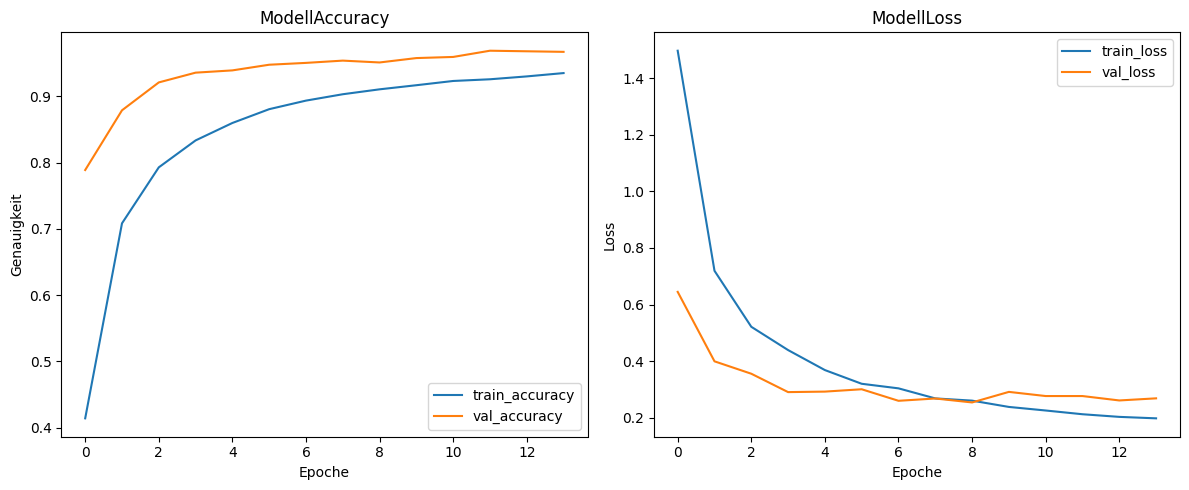

In [24]:
# --------------------------------------------------
# 8. Trainingsverlauf visualisieren
# --------------------------------------------------
plt.figure(figsize=(12, 5))

# Genauigkeit
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoche")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("ModellAccuracy")

# Verlust
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.title("ModellLoss")

plt.tight_layout()
plt.show()

In [25]:
# --------------------------------------------------
# 9. Modell auf Testdaten evaluieren
# --------------------------------------------------
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTestverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.9490 - loss: 0.1532

Testverlust: 0.1469
Testgenauigkeit: 0.9547


In [26]:
# --------------------------------------------------
# 10. Vorhersagen und Klassifikationsbericht
# --------------------------------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred))

print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred))

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step

Konfusionsmatrix:
[[481   0   0   0   0   2   0   0   1   0   0]
 [  1 505   0   0   0   0   0   0   1  21   0]
 [  0   0 529   0   2   0   0   0   0   0   0]
 [  0   0   0 531   2   0   5   0   0   0   0]
 [  0   0   7   6 520   0   0  19   0   0   0]
 [ 17   0   0   0   0 501   0   0  28   0   0]
 [  0   0   0   0   0   0 501   0   0   0   0]
 [  0   0   0   0  28   2   1 489   0   0   0]
 [  1   1   0   0   0  24   0   0 548   0   0]
 [  0  96   0   0   0   0   0   0   0 456   0]
 [  0   0   0   0   0   0   0   0   0   0 525]]

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       484
           1       0.84      0.96      0.89       528
           2       0.99      1.00      0.99       531
           3       0.99      0.99      0.99       538
           4       0.94      0.94      0.94       552
           5       0.95      0.92      0.93       546
           6    